In [16]:
pip install deepdiff scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import numpy as np
import os
import json
import re
from bs4 import BeautifulSoup, Comment
from deepdiff import DeepDiff
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from deepdiff.helper import SetOrdered
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from multiprocessing import Manager
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')



In [18]:
models = [
    "claude-3-7-sonnet-20250219",
    "claude-3-7-sonnet-20250219-non-reasoning",
    "deepseek-r1",
    "deepseek-v3-0324",
    "gpt-4.1",
    "llama3.3-70b",
    "o4-mini",
    "gpt-4o-mini",
    "qwen2.5-32b-instruct",
]

html_pages = [
    "airbnb",
    "ebay", 
    "github", 
    "medium", 
    "netflix", 
    "pinterest", 
    "quora", 
    "reddit", 
    "twitch", 
    "walmart", 
    "youtube",
    "facebook", 
    "twitter", 
    "linkedin", 
    "aliexpress"
] 

print("Loaded models:", models)

Loaded models: ['claude-3-7-sonnet-20250219', 'claude-3-7-sonnet-20250219-non-reasoning', 'deepseek-r1', 'deepseek-v3-0324', 'gpt-4.1', 'llama3.3-70b', 'o4-mini', 'gpt-4o-mini', 'qwen2.5-32b-instruct']


In [19]:
path_to_model_results = "./../results/reassembled"
path_to_originl_html = "./../dataset/original"

In [40]:
# get original html and modified html for each model in a dataframe
def get_html_df():
    html_data = []
    for model in models:
        for page in html_pages:
            original_html_path = os.path.join(path_to_originl_html, f"{page}.html")
            modified_html_path = os.path.join(path_to_model_results, model, f"{page}.html")
            with open(original_html_path, 'r', encoding='utf-8') as file:
                original_html = file.read()
                
            with open(modified_html_path, 'r', encoding='utf-8') as file:
                modified_html = file.read()
                modified_html = re.sub(r'<!--\s*Optimized by LLM.*?-->', '', modified_html, flags=re.DOTALL)
                modified_html = re.sub(r'<!--\s*End of Optimization.*?-->', '', modified_html, flags=re.DOTALL)
                modified_html = re.sub(r'<!--\s*Suggestion.*?-->', '', modified_html, flags=re.DOTALL)
                modified_html = re.sub(r'<!--\s*End of Suggestion.*?-->', '', modified_html, flags=re.DOTALL)
            html_data.append({
                "model": model,
                "page": page,
                "original": original_html,
                "modified": modified_html
            })
    return pd.DataFrame(html_data)

html_df = get_html_df()
print("HTML DataFrame details:")
print(html_df.info())

HTML DataFrame details:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   model     135 non-null    object
 1   page      135 non-null    object
 2   original  135 non-null    object
 3   modified  135 non-null    object
dtypes: object(4)
memory usage: 4.3+ KB
None


In [41]:
LLM_MARKERS = [
    'optimized by llm',
    'end of optimization',
    'suggestion',
    'end of suggestion',
]

def is_llm_comment(text: str) -> bool:
    return any(marker in text.lower() for marker in LLM_MARKERS)

In [42]:
def normalize_attrs(attrs):
    # Return sorted attributes so that order differences are ignored.
    return dict(sorted(attrs.items()))

# def html_to_dict(element):
#     """
#     Convert a BeautifulSoup element (or text/comment) to a structured dict,
#     extracting LLM comment nodes and attaching them to their parent elements.
#     """
#     # Handle LLM-specific comments
#     if isinstance(element, Comment):
#         comment_text = element.string or ''
#         if is_llm_comment(comment_text):
#             return {'llm_comment': comment_text.strip()}
#         return None  # drop non-LLM comments

#     # Handle non-tag text nodes
#     if not getattr(element, 'name', None):
#         text = element.string.strip() if element.string else ''
#         return text or None

#     # Process tag nodes
#     node = {
#         'tag': element.name,
#         'attrs': normalize_attrs(element.attrs),
#         'children': []
#     }
#     llm_comments = []

#     for child in element.children:
#         child_repr = html_to_dict(child)
#         # Collect LLM comments separately
#         if isinstance(child_repr, dict) and 'llm_comment' in child_repr:
#             llm_comments.append(child_repr['llm_comment'])
#             continue
#         # Skip empty or irrelevant nodes
#         if child_repr in (None, ''):
#             continue
#         node['children'].append(child_repr)

#     if llm_comments:
#         node['llm_comments'] = llm_comments

#     # Optionally include text content if present but no children
#     if not node['children']:
#         text = element.get_text(strip=True)
#         if text:
#             node['text'] = text

#     return node


def html_to_dict(element):
    """Convert a BeautifulSoup element to a structured dictionary."""
    if not hasattr(element, 'name') or element.name is None:
        # For text nodes, return the text stripped.
        return element.string.strip() if element.string else ''
    
    # Structure for the current tag.
    node = {
        "tag": element.name,
        "attrs": normalize_attrs(element.attrs),
        "children": []
    }
    
    # Include text if present (and not only whitespace)
    text = element.get_text(strip=True)
    if text:
        node["text"] = text
    
    # Process children recursively.
    for child in element.children:
        child_repr = html_to_dict(child)
        # Skip empty strings that may occur due to whitespace
        if child_repr not in ('', None):
            node["children"].append(child_repr)
    
    return node

def generate_html_structure(html_str):
    # Parse the HTML and get the body or root element.
    soup = BeautifulSoup(html_str, 'html.parser')
    # For a complete document, you might want soup.html or soup.body; adjust as needed.
    return html_to_dict(soup)


In [ ]:
# def generate_html_structures(index):
#     print(f"Processing row {index + 1}/{len(html_df)}...")
#     row = html_df.iloc[index]
#     # Sample usage:
#     original_html = row.get("original")
#     modified_html = row.get("modified")
    
#     # Ensure both original_html and modified_html are valid strings
#     if not isinstance(original_html, str) or not isinstance(modified_html, str):
#         print(f"Row {index} has invalid HTML data. Skipping...")
#         skipped_rows.append(index)
#         return

#     original_structure = generate_html_structure(original_html)
#     modified_structure = generate_html_structure(modified_html)
#     html_df.at[index, 'original_structure'] = original_structure
#     html_df.at[index, 'modified_structure'] = modified_structure

# def generate_html_diffs(index):
#     print(f"Comparing row {index + 1}/{len(html_df)}...")
#     row = html_df.iloc[index]
#     original_structure = row.get("original_structure")
#     modified_structure = row.get("modified_structure")
#     # Get differences (ignores formatting differences if canonicalization is effective)
#     diff = DeepDiff(original_structure, modified_structure, ignore_order=True)
#     html_df.at[index, 'diff'] = diff
    
#     # Check if the diff is empty
#     if not diff:
#         print(f"Row {index} has no differences.")

In [43]:
def process_structure(index: int, original_html: str, modified_html: str):
    try:
        if not isinstance(original_html, str) or not isinstance(modified_html, str):
            return index, None, None, True

        original_structure = generate_html_structure(original_html)
        modified_structure = generate_html_structure(modified_html)
        return index, original_structure, modified_structure, False
    except Exception as e:
        logging.error(f"Error processing row {index}: {e}")
        return index, None, None, True

def process_diff(index, original_structure, modified_structure):
    diff = DeepDiff(original_structure, modified_structure, ignore_order=True)
    return index, diff

In [44]:
manager = Manager()
skipped_rows = manager.list()

html_df['diff'] = None
html_df['original_structure'] = None
html_df['modified_structure'] = None

logging.info("Starting HTML structure generation...")
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            process_structure, 
            idx, 
            row['original'],
            row['modified']
        ): idx
        for idx, row in html_df.iterrows()
    }

    for future in tqdm(as_completed(futures), total=len(futures), desc="Structure Generation"):
        idx, orig_struct, mod_struct, skipped = future.result()
        if skipped:
            skipped_rows.append(idx)
            logging.warning(f"Row {idx} has invalid HTML data. Skipping...")
            continue
        html_df.at[idx, 'original_structure'] = orig_struct
        html_df.at[idx, 'modified_structure'] = mod_struct
logging.info("Structure generation completed.")
logging.info(f"Skipped rows: {len(skipped_rows)}")

[INFO] Starting HTML structure generation...
Structure Generation: 100%|██████████| 135/135 [00:13<00:00,  9.92it/s]
[INFO] Structure generation completed.
[INFO] Skipped rows: 0


In [ ]:
logging.info("Starting HTML diff comparison...")
valid_indices = [i for i in range(len(html_df)) if i not in skipped_rows]
logging.info(f"Valid indices for diff computation: {len(valid_indices)}")

# for idx in valid_indices:
#     logging.info(f"Comparing row {idx + 1}/{len(valid_indices)}...")
#     idx, diff = process_diff(
#         idx, 
#         html_df.at[idx, 'original_structure'], 
#         html_df.at[idx, 'modified_structure']
#     )
#     html_df.at[idx, 'diff'] = diff
with ThreadPoolExecutor(max_workers=7) as executor:
    futures = {
        executor.submit(
            process_diff, idx, html_df.at[idx, 'original_structure'], html_df.at[idx, 'modified_structure']
        ): idx
        for idx in valid_indices
    }

    for future in tqdm(as_completed(futures), total=len(futures), desc="Diff Computation"):
        idx, diff = future.result()
        html_df.at[idx, 'diff'] = diff
logging.info("Diff comparison completed.")

[INFO] Starting HTML diff comparison...
[INFO] Valid indices for diff computation: 135
[INFO] Comparing row 1/135...
[INFO] Comparing row 2/135...


In [ ]:
# store html_df to a jsonl file
output_file = "./../results/html_diffs.jsonl"
with open(output_file, 'w', encoding='utf-8') as f:
    for _, row in html_df.iterrows():
        json_line = row.to_json(orient='records', force_ascii=False)
        f.write(json_line + '\n')
logging.info(f"HTML diffs saved to {output_file}")

In [ ]:
# get html_df from the jsonl file
data = []
with open('./../results/html_diffs.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

html_df = pd.DataFrame(data)
logging.info("Loaded HTML diffs from JSONL file.")
logging.info(f"HTML DataFrame loaded with {len(html_df)} rows.")

In [63]:
diff_features = html_df[html_df["diff"].notnull() & (html_df["diff"] != '') & (html_df["diff"] != {})].copy()["diff"]

# remove changes that have Optimized by LLM or End of Optimization or chunk_script_ or chunk_style_, don't remove whole changes, just the ones with direct keys with these values
# diff_features = diff_features.apply(
#     lambda x: {k: v for k, v in x.items() if not any(substring in k for substring in ["Optimized by LLM", "End of Optimization", "chunk_script_", "chunk_style_"])}
# )

print(f"Number of rows with diff features: {diff_features.shape[0]}")

serializable_diff_features = diff_features.apply(
    lambda x: json.loads(json.dumps(x, default=lambda o: list(o) if isinstance(o, SetOrdered) else str(o)))
)

# store diff features in a json file
with open("diff_features.jsonl", "w", encoding='utf-8') as f:
    for feature in serializable_diff_features:
        f.write(json.dumps(feature, ensure_ascii=False) + "\n")

# # print first 1 row of diff features
# print("Diff features:")
# for i in range(10):
#     print(serializable_diff_features.iloc[i])


Number of rows with diff features: 135


In [64]:
def extract_features_from_diff(diff_dict):
    """
    Given a DeepDiff dictionary, extract a list of feature dictionaries.
    Each feature includes:
    - change_type (e.g., "values_changed", "dictionary_item_added", etc.)
    - diff_path (the key or identifier from the DeepDiff output)
    - depth (a simple numeric feature calculated as the count of '[' in diff_path)
    """
    features = []
    for change_type, entries in diff_dict.items():
        # Check if entries is a dict-like object or a SetOrdered
        if isinstance(entries, dict):
            diff_paths = list(entries.keys())
        elif isinstance(entries, SetOrdered):
            # For SetOrdered objects, convert to list directly
            diff_paths = list(entries)
        else:
            # Fallback: try to iterate directly if possible
            try:
                diff_paths = list(entries)
            except Exception as e:
                print(f"Unexpected entry type for {change_type}: {type(entries)}")
                continue

        for diff_path in diff_paths:
            depth = diff_path.count("children")  # A simple measure of depth in the path
            record = {
                "change_type": change_type,
                "diff_path": diff_path,
                "depth": depth,
            }
            features.append(record)
    return features

In [65]:
def process_features_for_model(model_name: str):
    # Example usage within your DataFrame processing loop:
    all_features = []
    for idx, row in html_df[html_df["model"] == model_name].iterrows():
        if row['diff'] is None or row['diff'] == {}:
            continue
        diff_val = row['diff']
        # Parse the diff if it is a JSON string
        if isinstance(diff_val, str):
            try:
                diff_obj = json.loads(diff_val)
            except Exception as e:
                print(f"Error parsing diff on row {idx}: {e}")
                continue
        else:
            diff_obj = diff_val

        feats = extract_features_from_diff(diff_obj)
        for feat in feats:
            # Optionally add additional context from the row
            # feat['original_chunk_id'] = row['original_chunk_id']
            # feat['name'] = row['name']
            # feat['dom_name'] = row['dom_name']
            all_features.append(feat)

    df_features = pd.DataFrame(all_features)
    # # Example code to summarize key stats in df_features
    # print("Change Types Distribution:\n", df_features["change_type"].value_counts())
    # print("\nMinimum Depth:", df_features["depth"].min())
    # print("Maximum Depth:", df_features["depth"].max())
    # print("Average Depth:", df_features["depth"].mean())
    # print("\nUnique Change Types:", df_features["change_type"].nunique())

    return df_features

In [ ]:
# get all the unique keys from the diff column
unique_change_keys = html_df['diff'].dropna().apply(lambda x: list(x.keys()) if isinstance(x, dict) else []).explode().unique()

changes_new_df = pd.DataFrame()
for key in unique_change_keys:
    unique_keys = html_df['diff'].dropna().apply(lambda x: x.get(key, {})).dropna().apply(
        lambda x: list(x.keys()) if isinstance(x, dict) else []
    ).dropna().explode()

    attr_changes = [k for k in unique_keys if 'attrs' in str(k)]
    tag_changes = [k for k in unique_keys if 'tag' in str(k)]
    text_changes = [k for k in unique_keys if str(k).endswith("'text']")]
    positional_changes = [k for k in unique_keys if 'children' in str(k) and 'attrs' not in str(k) and 'tag' not in str(k) and k not in attr_changes and k not in tag_changes and k not in text_changes]
    unaccounted_changes = [k for k in unique_keys if k not in attr_changes and k not in tag_changes and k not in positional_changes and k not in text_changes]
    # remove nan values from all lists
    attr_changes = [k for k in attr_changes if k is not None]
    tag_changes = [k for k in tag_changes if k is not None]
    positional_changes = [k for k in positional_changes if k is not None]
    text_changes = [k for k in text_changes if k is not None]
    unaccounted_changes = [k for k in unaccounted_changes if k is not None]

    item = {
        "key": key,
        "total_changes": len(unique_keys),
        # count the number of unique keys with "attrs" anywhere in the key e.g. ""root['children'][4]['children'][2]['children'][3]['attrs']['data-view']""
        "attr_changes": len(attr_changes),
        "tag_changes": len(tag_changes),
        "positional_changes": len(positional_changes),
        # count the number of unique_keys with "text" at the end of the key e.g. ""root['children'][4]['children'][1]['text']""
        "text_changes": len(text_changes),
        # get a list not the sum of unique keys that are not in attrs, tag, children or text
        "unaccounted_changes": len(unaccounted_changes),
        "unique_values": unique_keys if unique_keys is not None else [],
    }

    changes_new_df = pd.concat([changes_new_df, pd.DataFrame([item])], ignore_index=True)


print("Unique keys in diff column:\n", changes_new_df.head(10))
changes_new_df.to_csv("unique_diff_keys.csv", index=False)

print("Unaccounted Changes:\n") # Save them to a separate csv file
unaccounted_changes = changes_new_df['unaccounted_changes'].explode().dropna().tolist()  
unaccounted_changes_df = pd.DataFrame(unaccounted_changes, columns=['unaccounted_change']).dropna()
unaccounted_changes_df.to_csv("unaccounted_changes.csv", index=False)
# for idx, row in html_df.iterrows():
#     if row['diff'] is None or row['diff'] == {}:
#         print(f"Row {idx} has no diff, skipping...")
#         continue
#     try:
#         diff_val = row['diff']
#         print(diff_val.keys())

#         break
#     except Exception as e:
#         print(f"Error processing row {idx}: {e}")
#         continue


[nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:


# Example code to summarize key stats in df_features per model
all_model_features = pd.DataFrame()
stats = []
for model in models:
    print(f"Processing features for model: {model}")
    model_features = process_features_for_model(model)
    new_stats = {
        "model": model,
        # "num_features": model_features.shape[0],
        # all unique change types except 'type_changes'
        "unique_change_types": model_features["change_type"].nunique(),
        "min_depth": model_features["depth"].min(),
        "max_depth": model_features["depth"].max(),
        "avg_depth": model_features["depth"].mean(),
        # number for each change type
    }
    for change_type in model_features["change_type"].unique():
        new_stats[f"count_{change_type}"] = model_features[model_features["change_type"] == change_type].shape[0]
        # fill NaN with 0
        new_stats[f"count_{change_type}"] = new_stats.get(f"count_{change_type}", 0)
        
    stats.append(new_stats)

    all_model_features = pd.concat([all_model_features, model_features], ignore_index=True)

print("\nModel Features Summary:")
summary_df = pd.DataFrame(stats)
print(summary_df.head())

summary_df.to_csv("model_features_summary.csv", index=False)


Processing features for model: claude-3-7-sonnet-20250219
Processing features for model: claude-3-7-sonnet-20250219-non-reasoning
Processing features for model: deepseek-r1
Processing features for model: deepseek-v3-0324
Processing features for model: gpt-4.1
Processing features for model: llama3.3-70b
Processing features for model: o4-mini
Processing features for model: gpt-4o-mini
Processing features for model: qwen2.5-32b-instruct

Model Features Summary:
                                      model  num_features  \
0                claude-3-7-sonnet-20250219           157   
1  claude-3-7-sonnet-20250219-non-reasoning           159   
2                               deepseek-r1           134   
3                          deepseek-v3-0324           218   
4                                   gpt-4.1           212   

   unique_change_types  min_depth  max_depth  avg_depth  count_values_changed  \
0                    5          1          6   5.057325                    68   
1       

In [27]:
def get_clustering_features(df_features, model_name: str):
    print("Extracted Feature Records for Model:", model_name)
    path_to_features = f"./../results/features/{model_name}"

    if not os.path.exists(path_to_features):
        os.makedirs(path_to_features)

    df_features.to_csv(f"{path_to_features}/diff_features.csv", index=False)
    
    # ----------------------------------------------------------------------------
    # 2. Build a feature transformation pipeline.
    #
    # We use:
    #   - TfidfVectorizer on the diff_path string.
    #   - OneHotEncoder on the change_type.
    #   - StandardScaler on the numeric depth.
    # ----------------------------------------------------------------------------
    preprocessor = ColumnTransformer(
        transformers=[
            ('path_tf', TfidfVectorizer(), 'diff_path'),
            ('type_enc', OneHotEncoder(), ['change_type']),
            ('scaler', StandardScaler(), ['depth']),
        ],
        remainder='drop'  # drop any other columns
    )

    # Transform the DataFrame to a feature matrix.
    X_features = preprocessor.fit_transform(df_features)
    print("\nFeature matrix shape:", X_features.shape)

    return X_features


In [40]:
def process_hierarchical_clustering(model_name: str):
    df_features = process_features_for_model(model_name)

    X_features = get_clustering_features(df_features, model_name)
    # Convert your feature matrix from sparse to dense.
    X_dense = X_features.toarray()

    def custom_leaf_label(label):
        return label
        # Convert the label to a string in case it's not already a string.
        label_str = str(label)
        # Split the string by the delimiter, for example '['.
        parts = label_str.split('[')
        if parts:
            # Return the last part, stripping any extraneous characters.
            return parts[-1].strip("]'")
        return label_str


    # Now use X_dense in AgglomerativeClustering
    agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
    labels_hierarchical = agg_cluster.fit_predict(X_dense)
    df_features['hierarchical_cluster'] = labels_hierarchical

    print("\nHierarchical Clustering Results:")
    print(df_features[['diff_path', 'change_type', 'depth', 'hierarchical_cluster']])

    # Compute a linkage matrix for the dendrogram using the dense array.
    linkage_matrix = linkage(X_dense, method='ward')

    df_features['short_id'] = ["D" + str(i + 1) for i in range(len(df_features))]

    # Create a lookup table to reference full diff_path for each ID.
    lookup_table = df_features[['short_id', 'diff_path']]
    # print("Lookup Table (ID to Full Diff Path):")
    # print(lookup_table.to_string(index=False))

    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=df_features['short_id'].tolist(), leaf_rotation=90)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Diff Path")
    plt.ylabel("Linkage Distance/Level of Dissimilarity")
    plt.tight_layout()
    plt.axhline(y=6, color='r', linestyle='--')
    plt.show()

    plt.scatter(df_features['change_type'], df_features['depth'], c=labels_hierarchical)


    overall_score = silhouette_score(X_dense, labels_hierarchical)
    print(f"\nOverall Silhouette Score: {overall_score}")

    sample_scores = silhouette_samples(X_dense, labels_hierarchical)
    for cluster in np.unique(labels_hierarchical):
        mask = labels_hierarchical == cluster
        mean_cluster_score = sample_scores[mask].mean()
        print(f"Mean silhouette for cluster {cluster}: {mean_cluster_score:.3f}")


    # df_features.loc[df_features['short_id'].isin(['D71', 'D30'])].to_csv("selected_diffs.csv", index=False)

    cluster_groups = df_features.groupby('hierarchical_cluster')
    print(f"\nCluster Groups: {len(cluster_groups)}")
    for cluster_label, group in cluster_groups:
        # plt.figure()
        # group['change_type'].value_counts().plot(kind='bar')
        # plt.title(f"Cluster {cluster_label} - Change Type Distribution")
        # plt.xlabel("Change Type")
        # plt.ylabel("Frequency")
        # plt.show()

        print(f"Cluster {cluster_label}:")
        print("Number of entries:", len(group))
        # Print a sample of diff_path entries; you can also use the lookup table for full details.
        print(group[['short_id', 'change_type', 'depth']].head())
        print("Change type counts:")
        print(group['change_type'].value_counts())
        print("Depth statistics:")
        print("Min:", group['depth'].min())
        print("Max:", group['depth'].max())
        print("Mean:", group['depth'].mean())
        print("\n")

    print("\n--- Cluster Analysis ---")

    # 1. Inspect the raw members of each cluster
    for cluster_id in sorted(df_features['hierarchical_cluster'].unique()):
        print(f"\n--- Cluster {cluster_id} ({len(df_features[df_features['hierarchical_cluster']==cluster_id])} members) ---")
        display(
            df_features.loc[
                df_features['hierarchical_cluster']==cluster_id,
                ['short_id','diff_path','change_type','depth']
            ].reset_index(drop=True)
        )

    # 2. Change‑type distribution per cluster
    pivot = df_features.pivot_table(
        index='change_type',
        columns='hierarchical_cluster',
        aggfunc='size',
        fill_value=0
    )
    print(pivot)

    # 3. Average depth per cluster
    print(df_features.groupby('hierarchical_cluster')['depth'].mean())

    plt.figure(figsize=(10,5))
    dendrogram(
        linkage_matrix,
        labels=df_features['short_id'].tolist(),
        leaf_rotation=90,
        color_threshold=8        # same y‑value you used for plt.axhline
    )
    plt.axhline(y=8, color='r', linestyle='--')
    plt.show()

    return {
        "overall_silhouette_score": overall_score,
        "mean_silhouette_scores": {cluster: sample_scores[labels_hierarchical == cluster].mean() for cluster in np.unique(labels_hierarchical)},
        "stats_by_cluster": [
            {
                "count": len(group),
                "min_depth": group['depth'].min(),
                "max_depth": group['depth'].max(),
                "mean_depth": group['depth'].mean(),
                "change_type_counts": group['change_type'].value_counts().to_dict()
            }
            for cluster, group in df_features.groupby('hierarchical_cluster')
        ],
        "dendrogram": {
            "linkage_matrix": linkage_matrix.tolist(),
            "labels": df_features['short_id'].tolist()
        },
        "cluster_labels": labels_hierarchical.tolist(),
    }


In [42]:
def process_dbscan_clustering(model_name: str):
    df_features = process_features_for_model(model_name)
    X_features = get_clustering_features(df_features, model_name)
    
    # ----------------------------------------------------------------------------
    # 4. DBSCAN Clustering
    # ----------------------------------------------------------------------------
    # Assuming X_features is your feature matrix and already computed.

    X_dense = X_features.toarray() if hasattr(X_features, 'toarray') else X_features

    # Run DBSCAN clustering
    dbscan_cluster = DBSCAN(eps=1.41415, min_samples=4)
    labels_dbscan = dbscan_cluster.fit_predict(X_dense)
    df_features['dbscan_cluster'] = labels_dbscan

    print("\nDBSCAN Clustering Results:")
    print(df_features[['diff_path', 'change_type', 'depth', 'dbscan_cluster']])

    # Reduce the dimensions of the feature matrix to 2D using PCA.
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_dense)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))

    # Use DBSCAN labels for colors. Label -1 denotes noise.
    unique_labels = set(labels_dbscan)
    colors = plt.cm.get_cmap("Spectral", len(unique_labels))

    for label in unique_labels:
        # Create a mask for points in the cluster.
        mask = labels_dbscan == label
        # For noise, plot with a unique marker and color.
        if label == -1:
            # Noise plotted with black color.
            color = "k"
            marker = "x"
            label_text = "Noise"
        else:
            color = colors(label)
            marker = "o"
            label_text = f"Cluster {label}"
        
        plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                    c=[color],
                    marker=marker,
                    label=label_text,
                    edgecolors="k",
                    s=100,
                    alpha=0.7)

    plt.title("DBSCAN Clustering Visualization (via PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    mask = labels_dbscan != -1
    filtered_labels = labels_dbscan[mask]
    filtered_X = X_dense[mask]

    if len(np.unique(filtered_labels)) > 1:
        # Overall silhouette
        db_overall = silhouette_score(filtered_X, filtered_labels)
        print(f"DBSCAN overall silhouette (excluding noise): {db_overall:.3f}")

        # Per‑cluster means
        samples = silhouette_samples(filtered_X, filtered_labels)
        for lbl in np.unique(filtered_labels):
            print(f"Mean silhouette for DBSCAN cluster {lbl}: {samples[filtered_labels == lbl].mean():.3f}")
    else:
        print("Not enough non‑noise clusters to compute silhouette.")


    cluster_groups = df_features.groupby('dbscan_cluster')
    print(f"\nCluster Groups: {len(cluster_groups)}")
    for cluster_label, group in cluster_groups:
        # plt.figure()
        # group['change_type'].value_counts().plot(kind='bar')
        # plt.title(f"Cluster {cluster_label} - Change Type Distribution")
        # plt.xlabel("Change Type")
        # plt.ylabel("Frequency")
        # plt.show()

        print(f"Cluster {cluster_label}:")
        print("Number of entries:", len(group))
        # Print a sample of diff_path entries; you can also use the lookup table for full details.
        print(group[['change_type', 'depth']].head())
        print("Change type counts:")
        print(group['change_type'].value_counts())
        print("\n")

    return {
        "overall_silhouette_score": db_overall,
        "mean_silhouette_scores": {cluster: samples[filtered_labels == cluster].mean() for cluster in np.unique(filtered_labels)},
        "stats_by_cluster": [
            {
                "count": len(group),
                "min_depth": group['depth'].min(),
                "max_depth": group['depth'].max(),
                "mean_depth": group['depth'].mean(),
                "change_type_counts": group['change_type'].value_counts().to_dict()
            }
            for cluster, group in df_features.groupby('dbscan_cluster')
        ],
        "pca_components": X_reduced.tolist(),
        "cluster_labels": labels_dbscan.tolist()
    }


Processing model: claude-3-7-sonnet-20250219
Change Types Distribution:
 change_type
iterable_item_added      88
values_changed           66
iterable_item_removed     3
type_changes              1
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 6
Average Depth: 5.044303797468355

Unique Change Types: 4
Extracted Feature Records for Model: claude-3-7-sonnet-20250219

Feature matrix shape: (158, 95)

Hierarchical Clustering Results:
                                     diff_path     change_type  depth  \
0                  root['children'][1]['text']  values_changed      3   
1                                 root['text']  values_changed      1   
2           root['children'][1]['children'][1]  values_changed      4   
3           root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][2]['tag']  values_changed      5   
..                                         ...             ...    ...   
153         root['children'][1]['children']

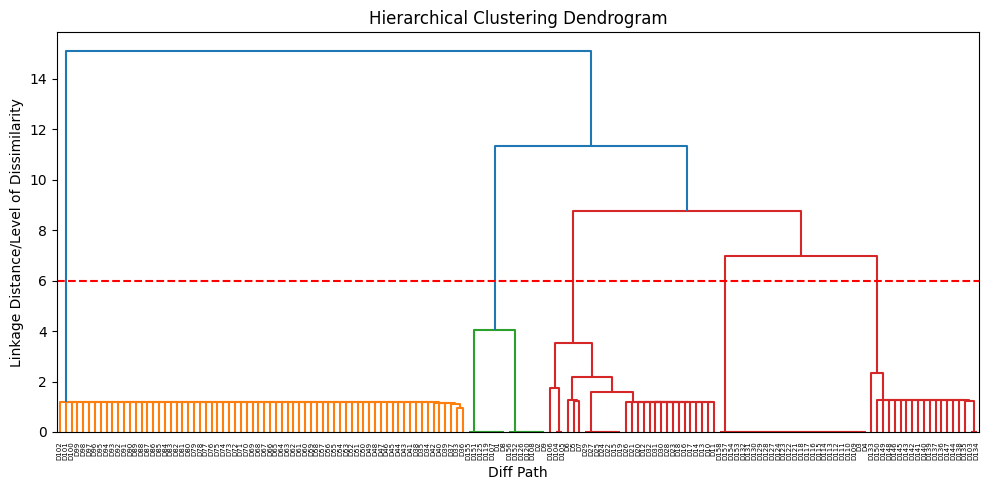


Overall Silhouette Score: 0.3353174943822803
Mean silhouette for cluster 0: 0.204
Mean silhouette for cluster 1: 0.408
Mean silhouette for cluster 2: 0.663

Cluster Groups: 3
Cluster 0:
Number of entries: 74
  short_id     change_type  depth
2       D3  values_changed      4
3       D4  values_changed      4
4       D5  values_changed      5
5       D6  values_changed      5
6       D7  values_changed      5
Change type counts:
change_type
values_changed           52
iterable_item_added      18
iterable_item_removed     3
type_changes              1
Name: count, dtype: int64
Depth statistics:
Min: 4
Max: 6
Mean: 4.716216216216216


Cluster 1:
Number of entries: 70
   short_id          change_type  depth
32      D33  iterable_item_added      6
33      D34  iterable_item_added      6
34      D35  iterable_item_added      6
35      D36  iterable_item_added      6
36      D37  iterable_item_added      6
Change type counts:
change_type
iterable_item_added    70
Name: count, dtype: int64
De

,short_id,diff_path,change_type,depth
0,D3,root['children'][1]['children'][1],values_changed,4
1,D4,root['children'][1]['children'][0],values_changed,4
2,D5,root['children'][4]['children'][2]['tag'],values_changed,5
3,D6,root['children'][4]['children'][2]['attrs'],values_changed,5
4,D7,root['children'][4]['children'][2]['text'],values_changed,5
...,...,...,...,...
69,D150,root['children'][1]['children'][34],iterable_item_added,4
70,D153,root['children'][1]['children'][1],values_changed,4
71,D154,root['children'][1]['children'][0],values_changed,4
72,D157,root['children'][1]['children'][1],values_changed,4



--- Cluster 1 (70 members) ---


,short_id,diff_path,change_type,depth
0,D33,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D34,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D35,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D36,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D37,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
65,D98,root['children'][4]['children'][2]['children']...,iterable_item_added,6
66,D99,root['children'][4]['children'][2]['children']...,iterable_item_added,6
67,D100,root['children'][4]['children'][2]['children']...,iterable_item_added,6
68,D101,root['children'][4]['children'][2]['children']...,iterable_item_added,6



--- Cluster 2 (14 members) ---


,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D8,root['children'][4]['text'],values_changed,3
3,D9,root['text'],values_changed,1
4,D107,root['children'][1]['text'],values_changed,3
5,D108,root['text'],values_changed,1
6,D119,root['children'][1]['text'],values_changed,3
7,D120,root['text'],values_changed,1
8,D125,root['children'][1]['text'],values_changed,3
9,D126,root['text'],values_changed,1


hierarchical_cluster    0   1   2
change_type                      
iterable_item_added    18  70   0
iterable_item_removed   3   0   0
type_changes            1   0   0
values_changed         52   0  14
hierarchical_cluster
0    4.716216
1    6.000000
2    2.000000
Name: depth, dtype: float64


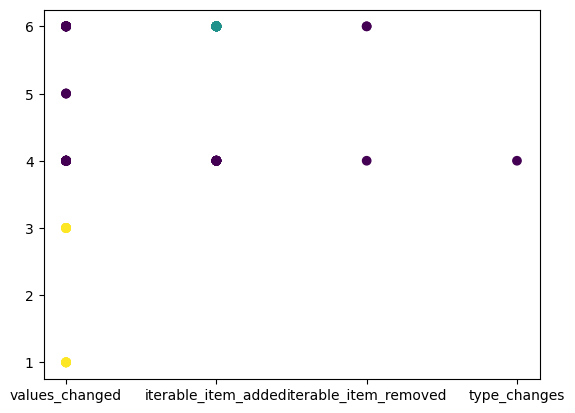

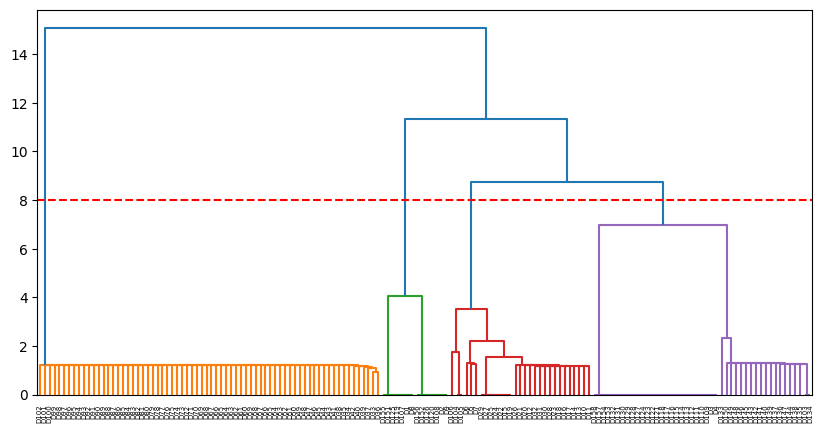

Processing model: claude-3-7-sonnet-20250219-non-reasoning
Change Types Distribution:
 change_type
iterable_item_added      80
values_changed           54
iterable_item_removed    23
dictionary_item_added     3
type_changes              2
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 8
Average Depth: 5.111111111111111

Unique Change Types: 5
Extracted Feature Records for Model: claude-3-7-sonnet-20250219-non-reasoning

Feature matrix shape: (162, 98)

Hierarchical Clustering Results:
                                             diff_path     change_type  depth  \
0                          root['children'][1]['text']  values_changed      3   
1                                         root['text']  values_changed      1   
2                   root['children'][1]['children'][1]  values_changed      4   
3                   root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][1]['children']...    type_changes      6   
..          

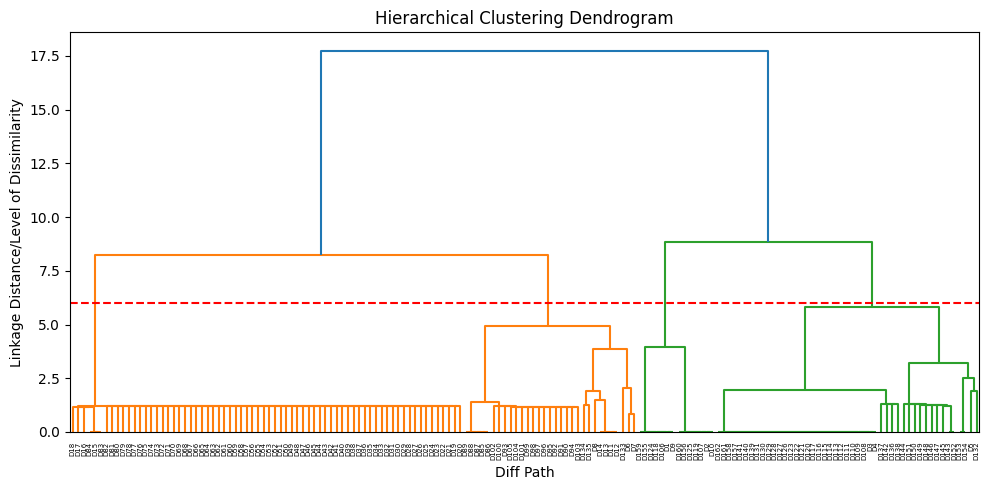


Overall Silhouette Score: 0.39253872575773746
Mean silhouette for cluster 0: 0.311
Mean silhouette for cluster 1: 0.508
Mean silhouette for cluster 2: 0.596

Cluster Groups: 3
Cluster 0:
Number of entries: 101
   short_id            change_type  depth
5        D6  dictionary_item_added      8
6        D7  dictionary_item_added      8
7        D8         values_changed      5
10      D11         values_changed      6
11      D12         values_changed      6
Change type counts:
change_type
iterable_item_added      70
iterable_item_removed    21
values_changed            7
dictionary_item_added     3
Name: count, dtype: int64
Depth statistics:
Min: 5
Max: 8
Mean: 6.03960396039604


Cluster 1:
Number of entries: 47
    short_id     change_type  depth
2         D3  values_changed      4
3         D4  values_changed      4
4         D5    type_changes      6
107     D108  values_changed      4
108     D109  values_changed      4
Change type counts:
change_type
values_changed           33
i

,short_id,diff_path,change_type,depth
0,D6,root['children'][4]['children'][1]['children']...,dictionary_item_added,8
1,D7,root['children'][4]['children'][1]['children']...,dictionary_item_added,8
2,D8,root['children'][4]['children'][2]['text'],values_changed,5
3,D11,root['children'][4]['children'][1]['children'][0],values_changed,6
4,D12,root['children'][4]['children'][2]['children'][3],values_changed,6
...,...,...,...,...
96,D104,root['children'][4]['children'][2]['children']...,iterable_item_removed,6
97,D105,root['children'][4]['children'][2]['children']...,iterable_item_removed,6
98,D133,root['children'][1]['children'][4]['attrs']['c...,dictionary_item_added,6
99,D134,root['children'][1]['children'][4]['attrs']['h...,values_changed,6



--- Cluster 1 (47 members) ---


,short_id,diff_path,change_type,depth
0,D3,root['children'][1]['children'][1],values_changed,4
1,D4,root['children'][1]['children'][0],values_changed,4
2,D5,root['children'][4]['children'][1]['children']...,type_changes,6
3,D108,root['children'][1]['children'][1],values_changed,4
4,D109,root['children'][1]['children'][0],values_changed,4
5,D110,root['children'][1]['children'][1],values_changed,4
6,D111,root['children'][1]['children'][0],values_changed,4
7,D112,root['children'][1]['children'][1],values_changed,4
8,D113,root['children'][1]['children'][0],values_changed,4
9,D114,root['children'][1]['children'][1],values_changed,4



--- Cluster 2 (14 members) ---


,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D9,root['children'][4]['text'],values_changed,3
3,D10,root['text'],values_changed,1
4,D106,root['children'][1]['text'],values_changed,3
5,D107,root['text'],values_changed,1
6,D118,root['children'][1]['text'],values_changed,3
7,D119,root['text'],values_changed,1
8,D124,root['children'][1]['text'],values_changed,3
9,D125,root['text'],values_changed,1


hierarchical_cluster    0   1   2
change_type                      
dictionary_item_added   3   0   0
iterable_item_added    70  10   0
iterable_item_removed  21   2   0
type_changes            0   2   0
values_changed          7  33  14
hierarchical_cluster
0    6.039604
1    4.042553
2    2.000000
Name: depth, dtype: float64


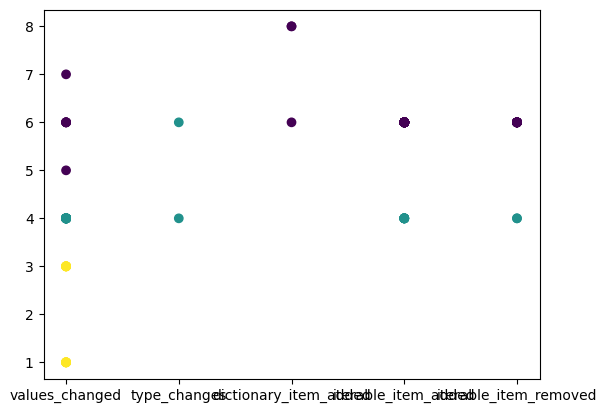

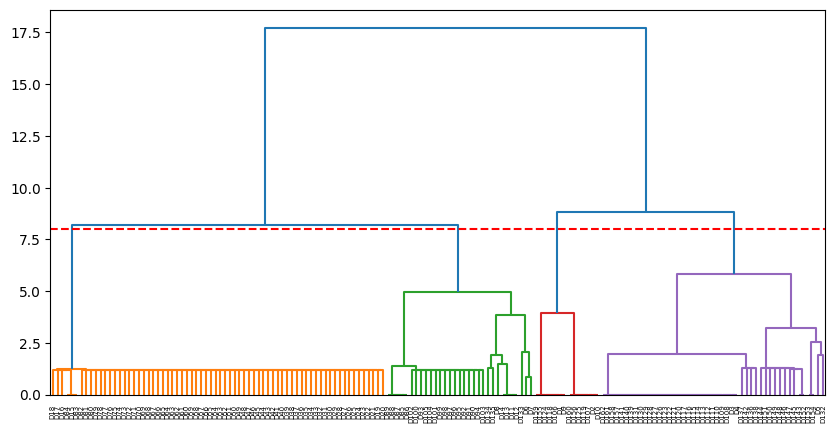

Processing model: deepseek-r1
Change Types Distribution:
 change_type
values_changed             63
iterable_item_added        38
iterable_item_removed      26
dictionary_item_removed     5
type_changes                4
dictionary_item_added       2
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 37
Average Depth: 5.065217391304348

Unique Change Types: 6
Extracted Feature Records for Model: deepseek-r1

Feature matrix shape: (138, 43)

Hierarchical Clustering Results:
                                             diff_path     change_type  depth  \
0                          root['children'][1]['text']  values_changed      3   
1                                         root['text']  values_changed      1   
2                   root['children'][1]['children'][1]  values_changed      4   
3                   root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][2]['children']...    type_changes      6   
..                           

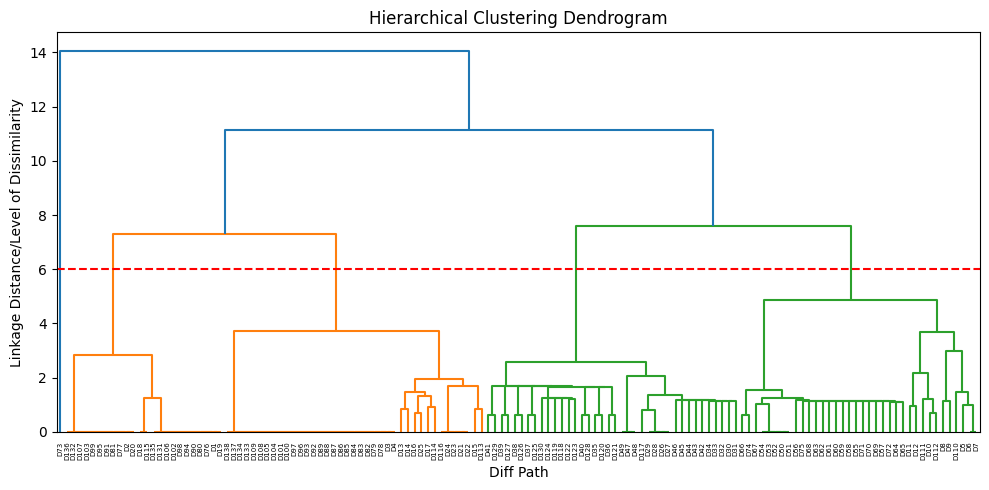


Overall Silhouette Score: 0.3197992722190333
Mean silhouette for cluster 0: 0.180
Mean silhouette for cluster 1: 0.000
Mean silhouette for cluster 2: 0.490

Cluster Groups: 3
Cluster 0:
Number of entries: 74
  short_id            change_type  depth
4       D5           type_changes      6
5       D6           type_changes      6
6       D7           type_changes      6
7       D8  dictionary_item_added      8
8       D9  dictionary_item_added      8
Change type counts:
change_type
iterable_item_added        38
iterable_item_removed      25
dictionary_item_removed     5
type_changes                4
dictionary_item_added       2
Name: count, dtype: int64
Depth statistics:
Min: 1
Max: 8
Mean: 5.662162162162162


Cluster 1:
Number of entries: 1
   short_id            change_type  depth
72      D73  iterable_item_removed     37
Change type counts:
change_type
iterable_item_removed    1
Name: count, dtype: int64
Depth statistics:
Min: 37
Max: 37
Mean: 37.0


Cluster 2:
Number of entries: 6

,short_id,diff_path,change_type,depth
0,D5,root['children'][4]['children'][2]['children']...,type_changes,6
1,D6,root['children'][4]['children'][2]['children'][5],type_changes,6
2,D7,root['children'][4]['children'][2]['children'][7],type_changes,6
3,D8,root['children'][4]['children'][2]['children']...,dictionary_item_added,8
4,D9,root['children'][4]['children'][2]['children']...,dictionary_item_added,8
...,...,...,...,...
69,D126,root['children'][1]['children'][25],iterable_item_added,4
70,D127,root['children'][1]['children'][26],iterable_item_added,4
71,D128,root['children'][1]['children'][27],iterable_item_added,4
72,D129,root['children'][1]['children'][28],iterable_item_added,4



--- Cluster 1 (1 members) ---


,short_id,diff_path,change_type,depth
0,D73,root['children'][4]['children'][2]['children']...,iterable_item_removed,37



--- Cluster 2 (63 members) ---


,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D3,root['children'][1]['children'][1],values_changed,4
3,D4,root['children'][1]['children'][0],values_changed,4
4,D13,root['children'][4]['children'][2]['children']...,values_changed,8
...,...,...,...,...
58,D134,root['children'][1]['children'][0],values_changed,4
59,D135,root['children'][1]['text'],values_changed,3
60,D136,root['text'],values_changed,1
61,D137,root['children'][1]['children'][1],values_changed,4


hierarchical_cluster      0  1   2
change_type                       
dictionary_item_added     2  0   0
dictionary_item_removed   5  0   0
iterable_item_added      38  0   0
iterable_item_removed    25  1   0
type_changes              4  0   0
values_changed            0  0  63
hierarchical_cluster
0     5.662162
1    37.000000
2     3.857143
Name: depth, dtype: float64


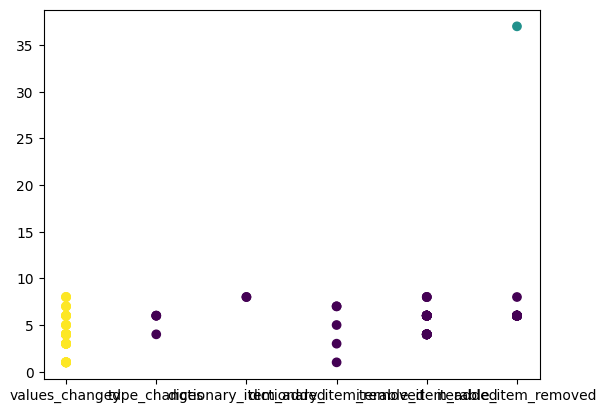

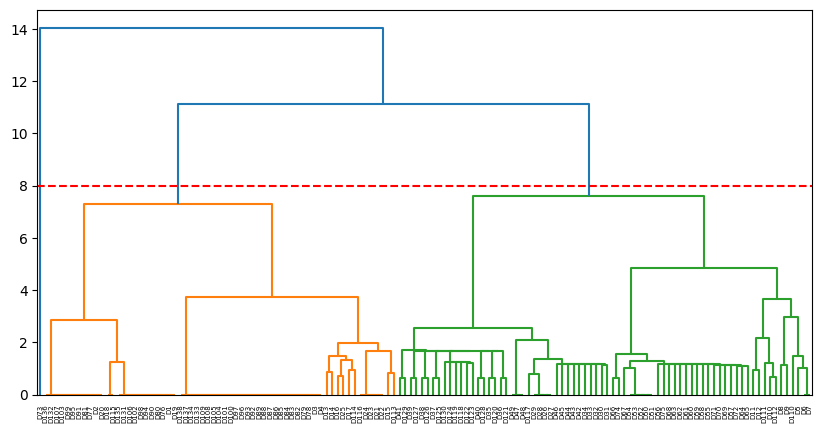

Processing model: deepseek-v3-0324
Change Types Distribution:
 change_type
iterable_item_added      113
values_changed           105
iterable_item_removed     13
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 6
Average Depth: 5.142857142857143

Unique Change Types: 3
Extracted Feature Records for Model: deepseek-v3-0324

Feature matrix shape: (231, 100)

Hierarchical Clustering Results:
                                     diff_path     change_type  depth  \
0                  root['children'][1]['text']  values_changed      3   
1                                 root['text']  values_changed      1   
2           root['children'][1]['children'][1]  values_changed      4   
3           root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][2]['tag']  values_changed      5   
..                                         ...             ...    ...   
226         root['children'][1]['children'][0]  values_changed      4   
227           

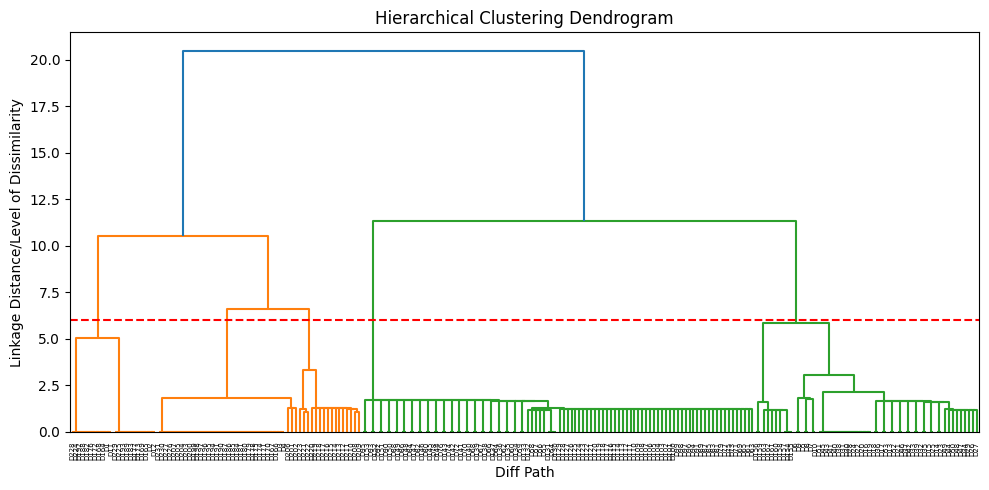


Overall Silhouette Score: 0.3333343231309612
Mean silhouette for cluster 0: 0.335
Mean silhouette for cluster 1: 0.309
Mean silhouette for cluster 2: 0.346

Cluster Groups: 3
Cluster 0:
Number of entries: 74
   short_id     change_type  depth
0        D1  values_changed      3
1        D2  values_changed      1
2        D3  values_changed      4
3        D4  values_changed      4
10      D11  values_changed      3
Change type counts:
change_type
values_changed           58
iterable_item_added      13
iterable_item_removed     3
Name: count, dtype: int64
Depth statistics:
Min: 1
Max: 4
Mean: 3.4054054054054053


Cluster 1:
Number of entries: 57
  short_id     change_type  depth
4       D5  values_changed      5
5       D6  values_changed      5
6       D7  values_changed      5
7       D8  values_changed      5
8       D9  values_changed      5
Change type counts:
change_type
values_changed           47
iterable_item_removed    10
Name: count, dtype: int64
Depth statistics:
Min: 5
Max:

,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D3,root['children'][1]['children'][1],values_changed,4
3,D4,root['children'][1]['children'][0],values_changed,4
4,D11,root['children'][4]['text'],values_changed,3
...,...,...,...,...
69,D227,root['children'][1]['children'][0],values_changed,4
70,D228,root['children'][1]['text'],values_changed,3
71,D229,root['text'],values_changed,1
72,D230,root['children'][1]['children'][1],values_changed,4



--- Cluster 1 (57 members) ---


,short_id,diff_path,change_type,depth
0,D5,root['children'][4]['children'][2]['tag'],values_changed,5
1,D6,root['children'][4]['children'][2]['attrs'],values_changed,5
2,D7,root['children'][4]['children'][2]['text'],values_changed,5
3,D8,root['children'][4]['children'][1]['tag'],values_changed,5
4,D9,root['children'][4]['children'][1]['attrs'],values_changed,5
5,D10,root['children'][4]['children'][1]['text'],values_changed,5
6,D13,root['children'][4]['children'][2]['children']...,values_changed,6
7,D14,root['children'][4]['children'][1]['children']...,values_changed,6
8,D15,root['children'][4]['children'][2]['children']...,values_changed,6
9,D16,root['children'][4]['children'][1]['children'][9],values_changed,6



--- Cluster 2 (100 members) ---


,short_id,diff_path,change_type,depth
0,D54,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D55,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D56,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D57,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D58,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
95,D149,root['children'][4]['children'][1]['children']...,iterable_item_added,6
96,D150,root['children'][4]['children'][1]['children']...,iterable_item_added,6
97,D151,root['children'][4]['children'][1]['children']...,iterable_item_added,6
98,D152,root['children'][4]['children'][1]['children']...,iterable_item_added,6


hierarchical_cluster    0   1    2
change_type                       
iterable_item_added    13   0  100
iterable_item_removed   3  10    0
values_changed         58  47    0
hierarchical_cluster
0    3.405405
1    5.894737
2    6.000000
Name: depth, dtype: float64


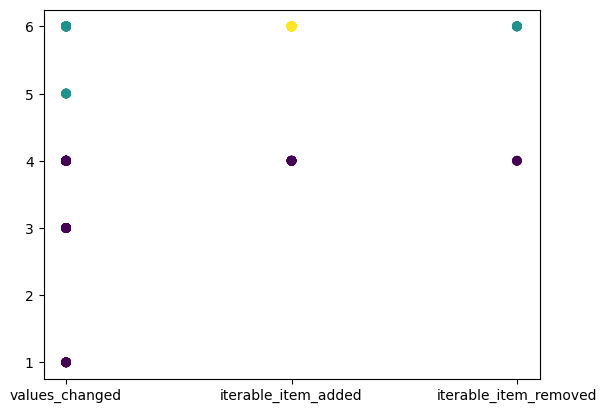

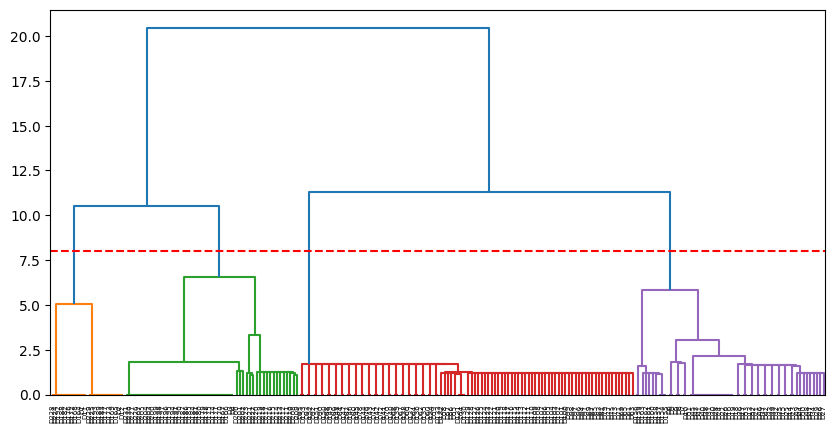

Processing model: gpt-4.1
Change Types Distribution:
 change_type
iterable_item_added      91
values_changed           70
iterable_item_removed     5
type_changes              1
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 6
Average Depth: 4.976047904191617

Unique Change Types: 4
Extracted Feature Records for Model: gpt-4.1

Feature matrix shape: (167, 100)

Hierarchical Clustering Results:
                                     diff_path     change_type  depth  \
0                  root['children'][1]['text']  values_changed      3   
1                                 root['text']  values_changed      1   
2           root['children'][1]['children'][1]  values_changed      4   
3           root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][2]['tag']  values_changed      5   
..                                         ...             ...    ...   
162         root['children'][1]['children'][0]  values_changed      4   
163    

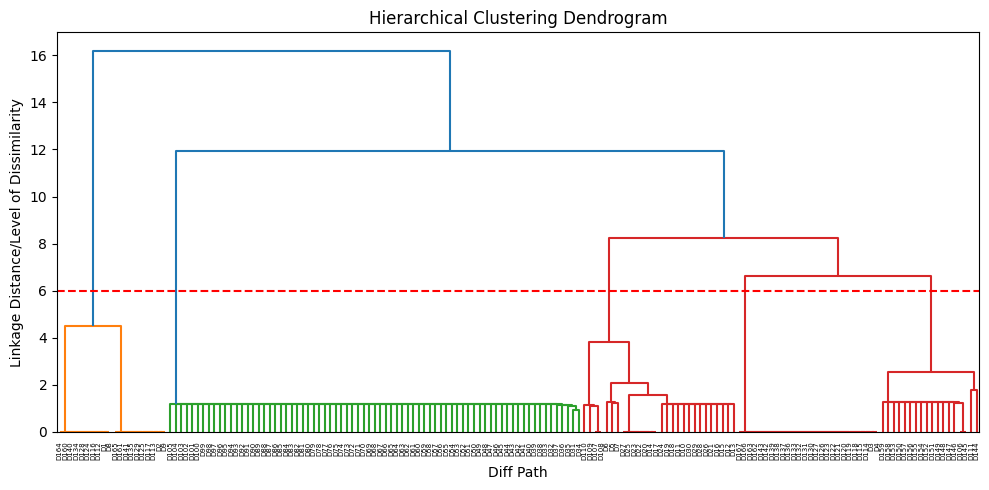


Overall Silhouette Score: 0.34623243907203616
Mean silhouette for cluster 0: 0.203
Mean silhouette for cluster 1: 0.679
Mean silhouette for cluster 2: 0.396

Cluster Groups: 3
Cluster 0:
Number of entries: 72
  short_id     change_type  depth
2       D3  values_changed      4
3       D4  values_changed      4
4       D5  values_changed      5
5       D6  values_changed      5
6       D7  values_changed      5
Change type counts:
change_type
values_changed           50
iterable_item_added      16
iterable_item_removed     5
type_changes              1
Name: count, dtype: int64
Depth statistics:
Min: 4
Max: 6
Mean: 4.736111111111111


Cluster 1:
Number of entries: 20
    short_id     change_type  depth
0         D1  values_changed      3
1         D2  values_changed      1
7         D8  values_changed      3
8         D9  values_changed      1
111     D112  values_changed      3
Change type counts:
change_type
values_changed    20
Name: count, dtype: int64
Depth statistics:
Min: 1
Max: 

,short_id,diff_path,change_type,depth
0,D3,root['children'][1]['children'][1],values_changed,4
1,D4,root['children'][1]['children'][0],values_changed,4
2,D5,root['children'][4]['children'][2]['tag'],values_changed,5
3,D6,root['children'][4]['children'][2]['attrs'],values_changed,5
4,D7,root['children'][4]['children'][2]['text'],values_changed,5
...,...,...,...,...
67,D159,root['children'][1]['children'][31],iterable_item_added,4
68,D162,root['children'][1]['children'][1],values_changed,4
69,D163,root['children'][1]['children'][0],values_changed,4
70,D166,root['children'][1]['children'][1],values_changed,4



--- Cluster 1 (20 members) ---


,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D8,root['children'][4]['text'],values_changed,3
3,D9,root['text'],values_changed,1
4,D112,root['children'][1]['text'],values_changed,3
5,D113,root['text'],values_changed,1
6,D116,root['children'][1]['text'],values_changed,3
7,D117,root['text'],values_changed,1
8,D124,root['children'][1]['text'],values_changed,3
9,D125,root['text'],values_changed,1



--- Cluster 2 (75 members) ---


,short_id,diff_path,change_type,depth
0,D31,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D32,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D33,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D34,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D35,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
70,D101,root['children'][4]['children'][2]['children']...,iterable_item_added,6
71,D102,root['children'][4]['children'][2]['children']...,iterable_item_added,6
72,D103,root['children'][4]['children'][2]['children']...,iterable_item_added,6
73,D104,root['children'][4]['children'][2]['children']...,iterable_item_added,6


hierarchical_cluster    0   1   2
change_type                      
iterable_item_added    16   0  75
iterable_item_removed   5   0   0
type_changes            1   0   0
values_changed         50  20   0
hierarchical_cluster
0    4.736111
1    2.000000
2    6.000000
Name: depth, dtype: float64


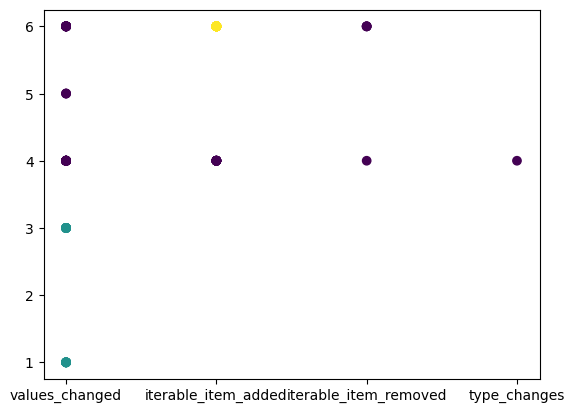

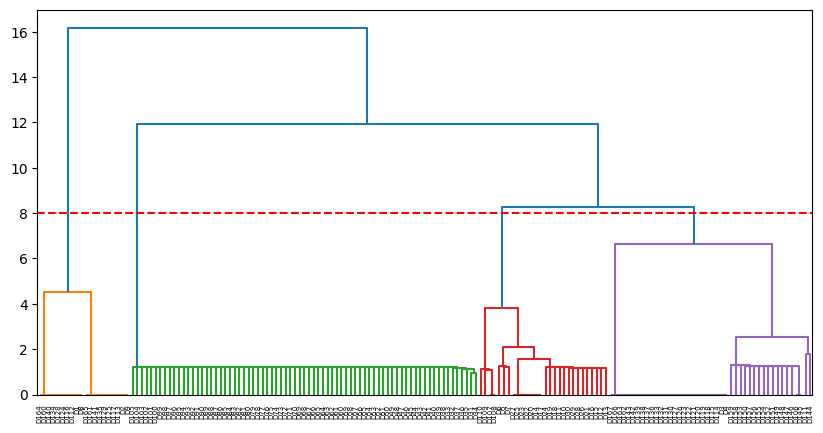

Processing model: llama3.3-70b
Change Types Distribution:
 change_type
values_changed             94
iterable_item_added        91
iterable_item_removed      21
dictionary_item_removed     4
type_changes                1
dictionary_item_added       1
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 17
Average Depth: 6.033018867924528

Unique Change Types: 6
Extracted Feature Records for Model: llama3.3-70b

Feature matrix shape: (212, 101)

Hierarchical Clustering Results:
                                             diff_path            change_type  \
0                          root['children'][1]['text']         values_changed   
1                                         root['text']         values_changed   
2                   root['children'][1]['children'][1]         values_changed   
3                   root['children'][1]['children'][0]         values_changed   
4            root['children'][4]['children'][2]['tag']         values_changed   
..                        

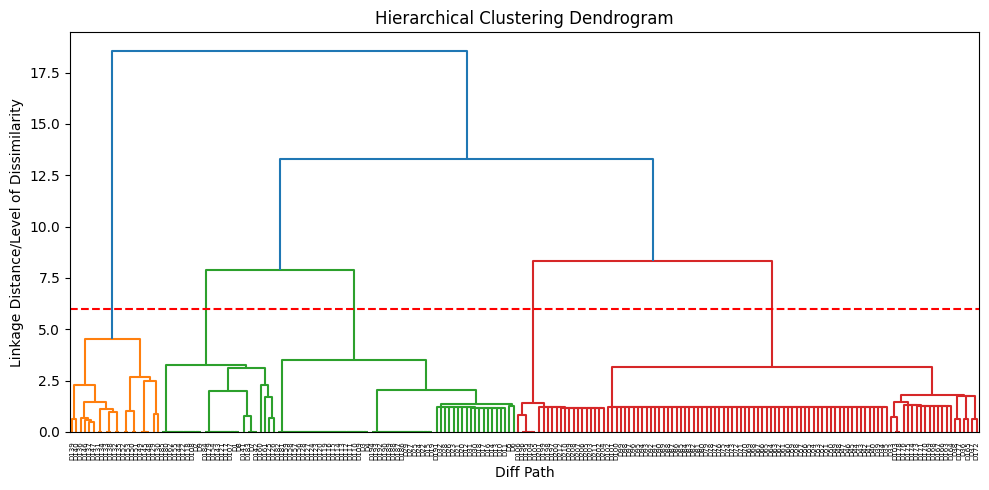


Overall Silhouette Score: 0.34300500857375643
Mean silhouette for cluster 0: 0.252
Mean silhouette for cluster 1: 0.544
Mean silhouette for cluster 2: 0.410

Cluster Groups: 3
Cluster 0:
Number of entries: 108
   short_id          change_type  depth
32      D33  iterable_item_added      6
33      D34  iterable_item_added      6
34      D35  iterable_item_added      6
35      D36  iterable_item_added      6
36      D37  iterable_item_added      6
Change type counts:
change_type
iterable_item_added      87
iterable_item_removed    21
Name: count, dtype: int64
Depth statistics:
Min: 4
Max: 6
Mean: 5.666666666666667


Cluster 1:
Number of entries: 21
    short_id              change_type  depth
128     D129  dictionary_item_removed     16
129     D130  dictionary_item_removed     16
130     D131           values_changed     13
131     D132           values_changed     13
132     D133           values_changed     13
Change type counts:
change_type
values_changed             15
iterable_ite

,short_id,diff_path,change_type,depth
0,D33,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D34,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D35,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D36,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D37,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
103,D208,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
104,D209,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
105,D210,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
106,D211,root['children'][1]['children'][1]['children']...,iterable_item_removed,6



--- Cluster 1 (21 members) ---


,short_id,diff_path,change_type,depth
0,D129,root['children'][1]['children'][1]['children']...,dictionary_item_removed,16
1,D130,root['children'][1]['children'][1]['children']...,dictionary_item_removed,16
2,D131,root['children'][1]['children'][1]['children']...,values_changed,13
3,D132,root['children'][1]['children'][1]['children']...,values_changed,13
4,D133,root['children'][1]['children'][1]['children']...,values_changed,13
5,D134,root['children'][1]['children'][1]['children']...,values_changed,13
6,D135,root['children'][1]['children'][1]['children']...,values_changed,13
7,D136,root['children'][1]['children'][1]['children']...,values_changed,15
8,D137,root['children'][1]['children'][1]['children']...,values_changed,15
9,D138,root['children'][1]['children'][1]['children']...,values_changed,13



--- Cluster 2 (83 members) ---


,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D3,root['children'][1]['children'][1],values_changed,4
3,D4,root['children'][1]['children'][0],values_changed,4
4,D5,root['children'][4]['children'][2]['tag'],values_changed,5
...,...,...,...,...
78,D190,root['children'][1]['children'][1]['children'][6],values_changed,6
79,D191,root['children'][1]['children'][1]['children']...,values_changed,6
80,D192,root['children'][1]['children'][1]['children'][2],values_changed,6
81,D193,root['children'][1]['children'][1]['children'][7],values_changed,6


hierarchical_cluster      0   1   2
change_type                        
dictionary_item_added     0   0   1
dictionary_item_removed   0   2   2
iterable_item_added      87   4   0
iterable_item_removed    21   0   0
type_changes              0   0   1
values_changed            0  15  79
hierarchical_cluster
0     5.666667
1    14.619048
2     4.337349
Name: depth, dtype: float64


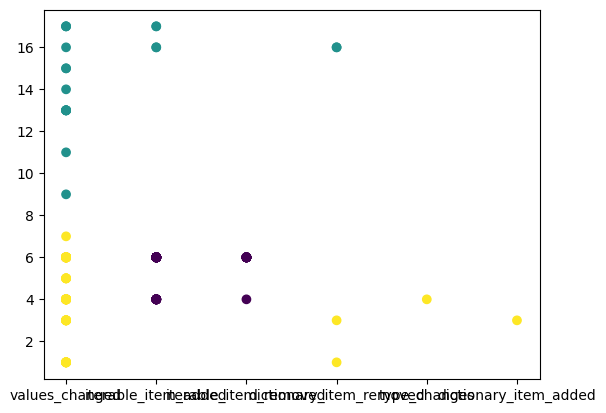

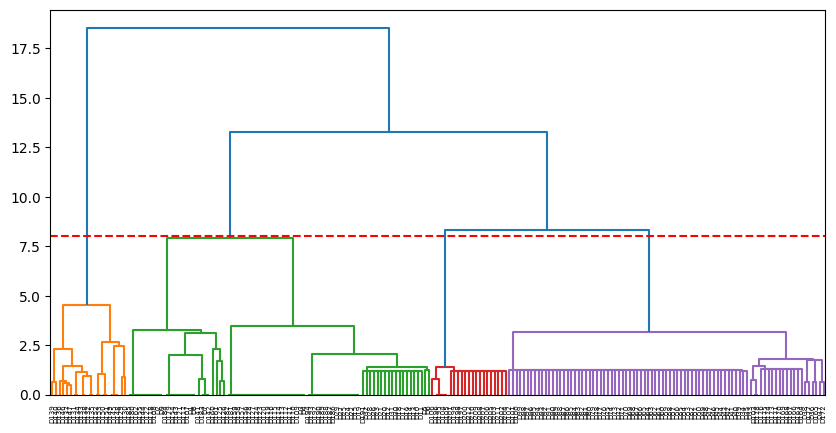

Processing model: o4-mini
Change Types Distribution:
 change_type
iterable_item_added      134
values_changed            97
iterable_item_removed     25
type_changes               1
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 6
Average Depth: 5.428015564202335

Unique Change Types: 4
Extracted Feature Records for Model: o4-mini

Feature matrix shape: (257, 95)

Hierarchical Clustering Results:
                                             diff_path            change_type  \
0                          root['children'][1]['text']         values_changed   
1                                         root['text']         values_changed   
2                   root['children'][1]['children'][1]         values_changed   
3                   root['children'][1]['children'][0]         values_changed   
4            root['children'][4]['children'][2]['tag']         values_changed   
..                                                 ...                    ...   
252  root['children']

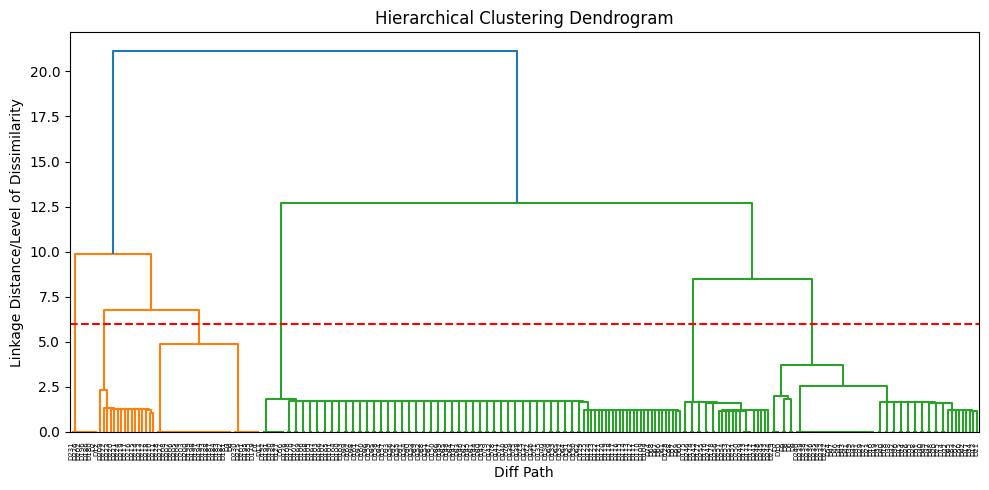


Overall Silhouette Score: 0.3228834563372679
Mean silhouette for cluster 0: 0.334
Mean silhouette for cluster 1: 0.274
Mean silhouette for cluster 2: 0.352

Cluster Groups: 3
Cluster 0:
Number of entries: 54
   short_id     change_type  depth
0        D1  values_changed      3
1        D2  values_changed      1
2        D3  values_changed      4
3        D4  values_changed      4
10      D11  values_changed      3
Change type counts:
change_type
values_changed         38
iterable_item_added    15
type_changes            1
Name: count, dtype: int64
Depth statistics:
Min: 1
Max: 4
Mean: 3.4074074074074074


Cluster 1:
Number of entries: 84
  short_id     change_type  depth
4       D5  values_changed      5
5       D6  values_changed      5
6       D7  values_changed      5
7       D8  values_changed      5
8       D9  values_changed      5
Change type counts:
change_type
values_changed           59
iterable_item_removed    25
Name: count, dtype: int64
Depth statistics:
Min: 5
Max: 6
Mea

,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D3,root['children'][1]['children'][1],values_changed,4
3,D4,root['children'][1]['children'][0],values_changed,4
4,D11,root['children'][4]['text'],values_changed,3
5,D12,root['text'],values_changed,1
6,D179,root['children'][1]['text'],values_changed,3
7,D180,root['text'],values_changed,1
8,D181,root['children'][1]['children'][1],values_changed,4
9,D182,root['children'][1]['children'][0],values_changed,4



--- Cluster 1 (84 members) ---


,short_id,diff_path,change_type,depth
0,D5,root['children'][4]['children'][2]['tag'],values_changed,5
1,D6,root['children'][4]['children'][2]['attrs'],values_changed,5
2,D7,root['children'][4]['children'][2]['text'],values_changed,5
3,D8,root['children'][4]['children'][1]['tag'],values_changed,5
4,D9,root['children'][4]['children'][1]['attrs'],values_changed,5
...,...,...,...,...
79,D253,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
80,D254,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
81,D255,root['children'][1]['children'][1]['children']...,iterable_item_removed,6
82,D256,root['children'][1]['children'][1]['children']...,iterable_item_removed,6



--- Cluster 2 (119 members) ---


,short_id,diff_path,change_type,depth
0,D56,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D57,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D58,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D59,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D60,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
114,D170,root['children'][4]['children'][1]['children']...,iterable_item_added,6
115,D189,root['children'][1]['children'][0]['children'][6],iterable_item_added,6
116,D190,root['children'][1]['children'][0]['children'][7],iterable_item_added,6
117,D191,root['children'][1]['children'][0]['children'][8],iterable_item_added,6


hierarchical_cluster    0   1    2
change_type                       
iterable_item_added    15   0  119
iterable_item_removed   0  25    0
type_changes            1   0    0
values_changed         38  59    0
hierarchical_cluster
0    3.407407
1    5.916667
2    6.000000
Name: depth, dtype: float64


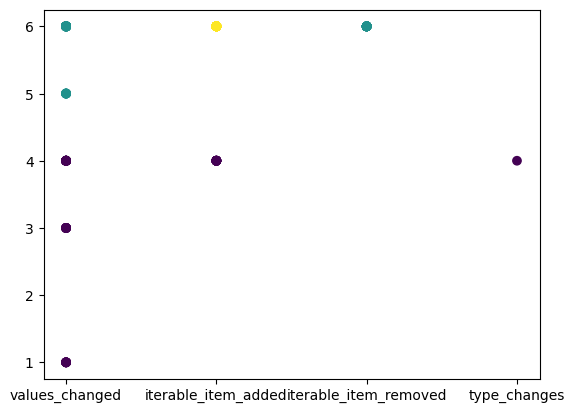

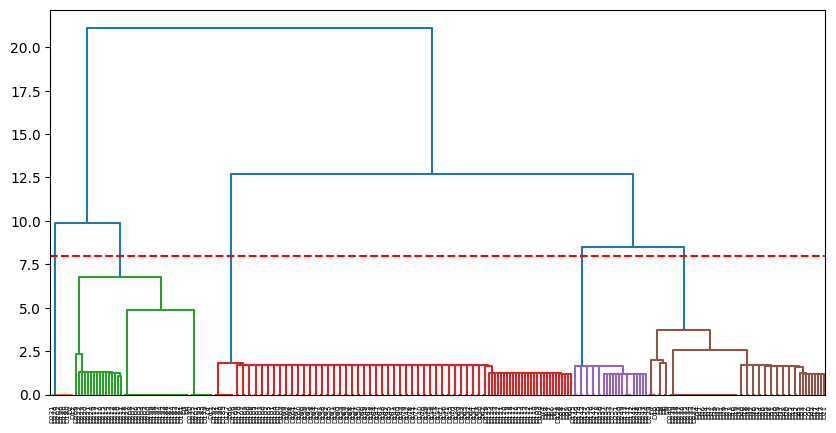

Processing model: qwen2.5-32b-instruct
Change Types Distribution:
 change_type
values_changed             106
iterable_item_added         70
iterable_item_removed       17
dictionary_item_removed      2
type_changes                 1
Name: count, dtype: int64

Minimum Depth: 1
Maximum Depth: 17
Average Depth: 5.994897959183674

Unique Change Types: 5
Extracted Feature Records for Model: qwen2.5-32b-instruct

Feature matrix shape: (196, 80)

Hierarchical Clustering Results:
                                     diff_path     change_type  depth  \
0                  root['children'][1]['text']  values_changed      3   
1                                 root['text']  values_changed      1   
2           root['children'][1]['children'][1]  values_changed      4   
3           root['children'][1]['children'][0]  values_changed      4   
4    root['children'][4]['children'][2]['tag']  values_changed      5   
..                                         ...             ...    ...   
191        

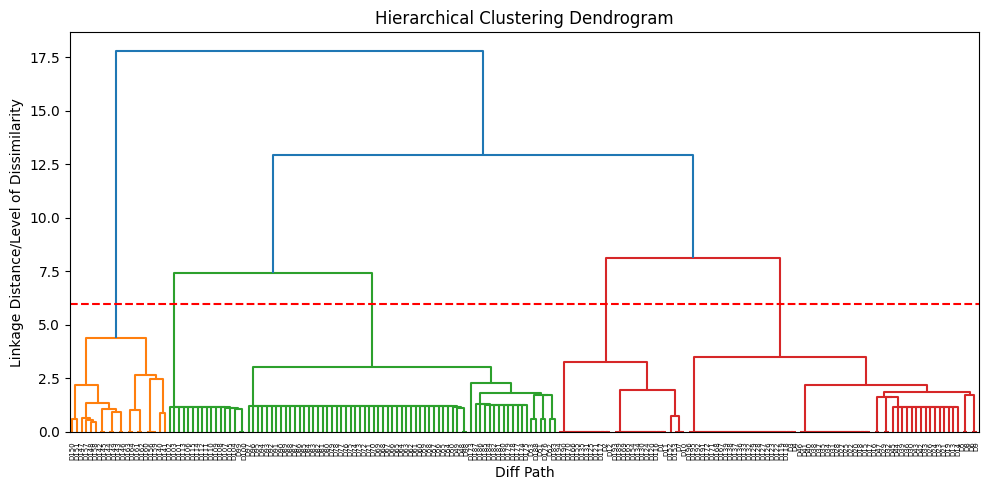


Overall Silhouette Score: 0.36811530998921804
Mean silhouette for cluster 0: 0.450
Mean silhouette for cluster 1: 0.538
Mean silhouette for cluster 2: 0.238

Cluster Groups: 3
Cluster 0:
Number of entries: 91
  short_id     change_type  depth
0       D1  values_changed      3
1       D2  values_changed      1
2       D3  values_changed      4
3       D4  values_changed      4
4       D5  values_changed      5
Change type counts:
change_type
values_changed    91
Name: count, dtype: int64
Depth statistics:
Min: 1
Max: 7
Mean: 4.351648351648351


Cluster 1:
Number of entries: 21
    short_id              change_type  depth
139     D140  dictionary_item_removed     16
140     D141  dictionary_item_removed     16
141     D142           values_changed     13
142     D143           values_changed     13
143     D144           values_changed     13
Change type counts:
change_type
values_changed             15
iterable_item_added         4
dictionary_item_removed     2
Name: count, dtype: int6

,short_id,diff_path,change_type,depth
0,D1,root['children'][1]['text'],values_changed,3
1,D2,root['text'],values_changed,1
2,D3,root['children'][1]['children'][1],values_changed,4
3,D4,root['children'][1]['children'][0],values_changed,4
4,D5,root['children'][4]['children'][2]['tag'],values_changed,5
...,...,...,...,...
86,D192,root['children'][1]['children'][0],values_changed,4
87,D193,root['children'][1]['text'],values_changed,3
88,D194,root['text'],values_changed,1
89,D195,root['children'][1]['children'][1],values_changed,4



--- Cluster 1 (21 members) ---


,short_id,diff_path,change_type,depth
0,D140,root['children'][1]['children'][1]['children']...,dictionary_item_removed,16
1,D141,root['children'][1]['children'][1]['children']...,dictionary_item_removed,16
2,D142,root['children'][1]['children'][1]['children']...,values_changed,13
3,D143,root['children'][1]['children'][1]['children']...,values_changed,13
4,D144,root['children'][1]['children'][1]['children']...,values_changed,13
5,D145,root['children'][1]['children'][1]['children']...,values_changed,13
6,D146,root['children'][1]['children'][1]['children']...,values_changed,13
7,D147,root['children'][1]['children'][1]['children']...,values_changed,15
8,D148,root['children'][1]['children'][1]['children']...,values_changed,15
9,D149,root['children'][1]['children'][1]['children']...,values_changed,13



--- Cluster 2 (84 members) ---


,short_id,diff_path,change_type,depth
0,D48,root['children'][4]['children'][2]['children'][4],iterable_item_added,6
1,D49,root['children'][4]['children'][2]['children']...,iterable_item_added,6
2,D50,root['children'][4]['children'][2]['children']...,iterable_item_added,6
3,D51,root['children'][4]['children'][2]['children']...,iterable_item_added,6
4,D52,root['children'][4]['children'][2]['children']...,iterable_item_added,6
...,...,...,...,...
79,D184,root['children'][1]['children'][26],iterable_item_added,4
80,D185,root['children'][1]['children'][27],iterable_item_added,4
81,D186,root['children'][1]['children'][28],iterable_item_added,4
82,D187,root['children'][1]['children'][29],iterable_item_added,4


hierarchical_cluster      0   1   2
change_type                        
dictionary_item_removed   0   2   0
iterable_item_added       0   4  66
iterable_item_removed     0   0  17
type_changes              0   0   1
values_changed           91  15   0
hierarchical_cluster
0     4.351648
1    14.619048
2     5.619048
Name: depth, dtype: float64


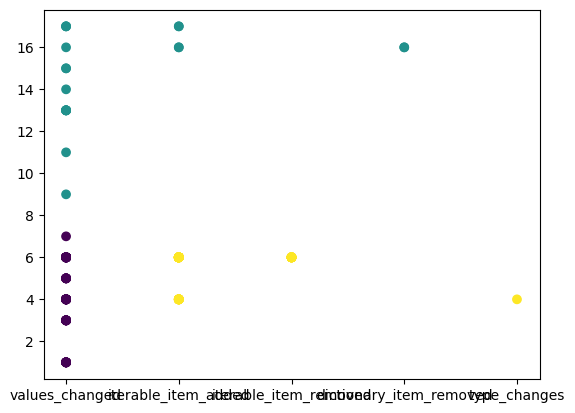

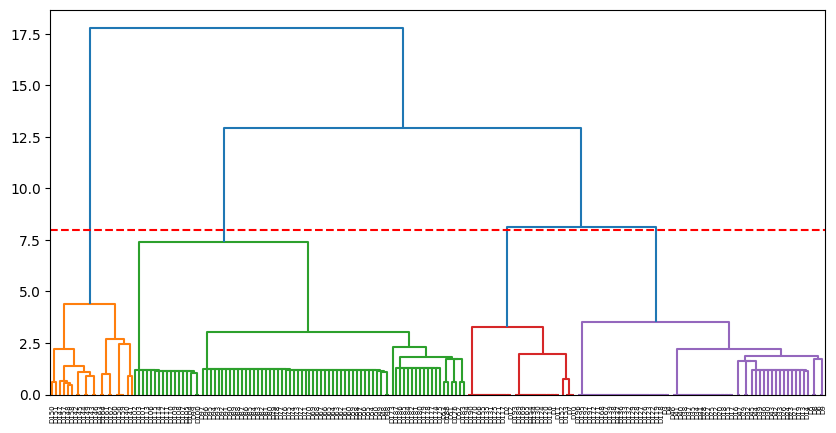

In [48]:
summaries = []
for model in models:
    print(f"Processing model: {model}")
    results = process_hierarchical_clustering(model)

    summaries.append({
        "model": model,
        "overall_silhouette_score": results['overall_silhouette_score'],
        "mean_silhouette_scores": results['mean_silhouette_scores'],
        "min_depth": [cluster['min_depth'] for cluster in results['stats_by_cluster']],
        "max_depth": [cluster['max_depth'] for cluster in results['stats_by_cluster']],
        "mean_depth": [cluster['mean_depth'] for cluster in results['stats_by_cluster']],
        "change_type_counts": [cluster['change_type_counts'] for cluster in results['stats_by_cluster']],
        "cluster_labels": results['cluster_labels']
    })

analysis_df = pd.DataFrame(summaries)
path_to_analysis = "./../results/analysis/summary.csv"
analysis_df.to_csv(path_to_analysis, index=False)


# total_analysis_df = pd.DataFrame()
# for model in models:
#     total_analysis_df['model'] = model
#     total_analysis_df['number_of_clusters'] = analysis_df['hierarchical']['stats_by_cluster'].keys()
#     # for only the hierarchical clustering, get a comparison of the number of clusters, mean depth, max depth, min depth, and change type counts 
#     analysis_df = pd.read_csv(f"./../results/analysis/{model}_analysis.csv")
    



In [ ]:
# compare results for each model in analysis_df

print(analysis_df['model', 'overall_silhouette_score'].head(10))

0    0.335317
1    0.392539
2    0.319799
3    0.333334
4    0.346232
5    0.343005
6    0.322883
7    0.368115
Name: overall_silhouette_score, dtype: float64
